In [1]:
# Proof of Concept: advection-diffusion equation
# created by Ethan Young, Aug 2024
# %reset -f

import dolfinx
import ufl
import numpy as np
import matplotlib.pyplot as plt

from mpi4py import MPI
from petsc4py import PETSc

In [6]:
def main(params, stability=False):
    comm = MPI.COMM_WORLD

    nx = 128

    # ================================================================
    # mesh, elements, function spaces, test and trial
    # ================================================================

    mesh = dolfinx.mesh.create_unit_square(comm, nx, nx)

    fe = ufl.FiniteElement("CG", mesh.ufl_cell(), degree=1)
    ve = ufl.VectorElement("CG", mesh.ufl_cell(), degree=2)

    Q = dolfinx.fem.FunctionSpace(mesh, fe)
    V = dolfinx.fem.FunctionSpace(mesh, ve)

    u = ufl.TrialFunction(Q)
    v = ufl.TestFunction(Q)

    temperature = dolfinx.fem.Function(Q, name="temperature")

    # ================================================================
    # Values that set the dynamics tradeoff/importance
    # ================================================================
    alpha = dolfinx.fem.Constant(mesh, params["alpha"])
    hot = params["hot_wall"]
    vel_scale = params["vel_scale"]

    # ================================================================
    # Make a dummy velocity field (Taylor-Green vortex)
    # ================================================================
    class VelocityAssigner:
        def __init__(self, vel_scale):
            self.vel_scale = vel_scale
            pass

        def __call__(self, x):
            vel = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)

            # Taylor-Green Vortex in a box
            vel[0] = self.vel_scale * np.sin(x[0] * np.pi) * np.cos(x[1] * np.pi)
            vel[1] = self.vel_scale * -np.cos(x[0] * np.pi) * np.sin(x[1] * np.pi)

            return vel


    velocity = dolfinx.fem.Function(V, name="velocity")
    velocity.interpolate(VelocityAssigner(vel_scale))

    # ================================================================
    # Set boundary conditions on temperature walls
    # marker -> entities -> dofs -> BCs
    # ================================================================
    def _ylo_wall(x):
        return np.isclose(x[1], 0.0)

    def _yhi_wall(x):
        return np.isclose(x[1], 1.0)

    ylo_entities = dolfinx.mesh.locate_entities_boundary(mesh, dim=1, marker=_ylo_wall)
    yhi_entities = dolfinx.mesh.locate_entities_boundary(mesh, dim=1, marker=_yhi_wall)

    ylo_dofs = dolfinx.fem.locate_dofs_topological(Q, entity_dim=1, entities=ylo_entities)
    yhi_dofs = dolfinx.fem.locate_dofs_topological(Q, entity_dim=1, entities=yhi_entities)

    bcs = []

    bcs.append(dolfinx.fem.dirichletbc(hot, dofs=ylo_dofs, V=Q))
    bcs.append(dolfinx.fem.dirichletbc(-hot, dofs=yhi_dofs, V=Q))

    # ================================================================
    # Write the form: u \dot T - alpha * nabla ^ 2 T = 0
    # ================================================================
    constant_zero = dolfinx.fem.Constant(mesh, 0.0)

    a = alpha * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
    a += ufl.inner(ufl.dot(velocity, ufl.nabla_grad(u)), v) * ufl.dx
    
#     c1 = inner(grad(v), grad(self.p_k))*dx
#     c1 = 0.0
#     c2 = ufl.inner(v, ufl.dot(velocity, ufl.nabla_grad(u)))*ufl.dx
#     eps = 0.9
#     stab = eps*c1 - eps*c2
#     a += stab
    
    # Residual, think this is just writing the "strong" governing equation?
    r = ufl.dot(velocity, ufl.nabla_grad(u)) - alpha*ufl.div(ufl.grad(u))

    # Add SUPG stabilization, depends on the residual, velocity magnitude, and local mesh size
    vnorm = ufl.sqrt(ufl.dot(velocity, velocity))
    h = ufl.CellDiameter(mesh)
    delta = h/(2.0*vnorm)
    stab = delta*ufl.dot(velocity, ufl.grad(v))*r*ufl.dx
    
    if stability:
        a += stab
    
    L = ufl.inner(constant_zero, v) * ufl.dx

    a = dolfinx.fem.form(a)
    L = dolfinx.fem.form(L)

    # ================================================================
    # Assemble and solve
    # ================================================================
    # Assemble the LHS matrix
    A = dolfinx.fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()

    # Assemble the RHS vector
    b = dolfinx.fem.petsc.assemble_vector(L)

    # Build the solver object for the temperature
    temperature_solver = PETSc.KSP().create(comm)

    temperature_solver.setOperators(A)

    temperature_solver.setType("preonly")
    temperature_solver.getPC().setType("lu")
    
#     temperature_solver.setType("cg")
#     temperature_solver.getPC().setType("jacobi")
#     temperature_solver.getPC().setHYPREType("euclid")
#     euclid, pilut, parasails, boomeramg, ams

    temperature_solver.view()
        
    temperature_solver.setFromOptions()

    # Apply boundary conditions
    dolfinx.fem.petsc.apply_lifting(b, [a], [bcs])

    b.ghostUpdate(
        addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE
    )

    dolfinx.fem.petsc.set_bc(b, bcs)

    # Solve the system
    temperature_solver.solve(b, temperature.vector)
    temperature.x.scatter_forward()

    # ================================================================
    # Print outputs, save paraview files
    # ================================================================

    cbar = plt.scatter(mesh.geometry.x[:, 0], mesh.geometry.x[:, 1], c=temperature.x.array[:], s=50)
    plt.colorbar(cbar)
    plt.show()

    for k, pt in enumerate(mesh.geometry.x):
        if np.isclose(pt[0], 0.5):
            plt.plot(pt[1], temperature.x.array[k], "x", color="C0")
    plt.title("Temperature profile along vertical midline")
    plt.xlabel("y-position")
    plt.ylabel("temperature")
    
    print(f"vel-to-alpha scaling: {params['vel_scale']/params['alpha']:.2f}")
    
    plt.show()

    # Save the results
    if stability:
        with dolfinx.io.XDMFFile(comm, "low_alpha_temp_stab.xdmf", "w") as fp:
            fp.write_mesh(mesh)
            fp.write_function(temperature, 0.0)
            fp.write_function(velocity, 0.0)
    
    else:
        with dolfinx.io.XDMFFile(comm, "low_alpha_temp_nostab.xdmf", "w") as fp:
            fp.write_mesh(mesh)
            fp.write_function(temperature, 0.0)
            fp.write_function(velocity, 0.0)
    
    
params = {}
params["hot_wall"] = 100.0
params["vel_scale"] = 1.0
params["alpha"] = 1.0e-4

KSP Object: 1 MPI process
  type: preonly
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
  left preconditioning
  using DEFAULT norm type for convergence test
PC Object: 1 MPI process
  type: lu
  PC has not been set up so information may be incomplete
    out-of-place factorization
    tolerance for zero pivot 2.22045e-14
  linear system matrix = precond matrix:
  Mat Object: 1 MPI process
    type: seqaij
    rows=16641, cols=16641
    total: nonzeros=115457, allocated nonzeros=115457
    total number of mallocs used during MatSetValues calls=0
      not using I-node routines


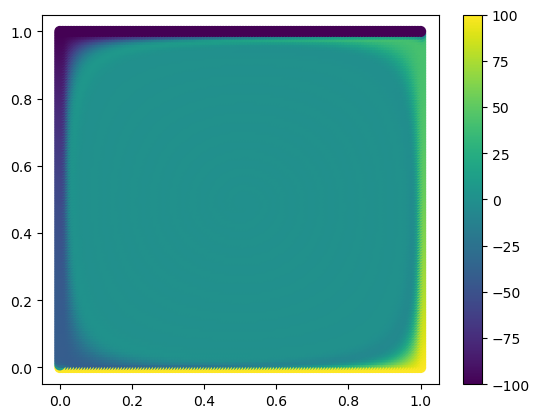

vel-to-alpha scaling: 10000.00


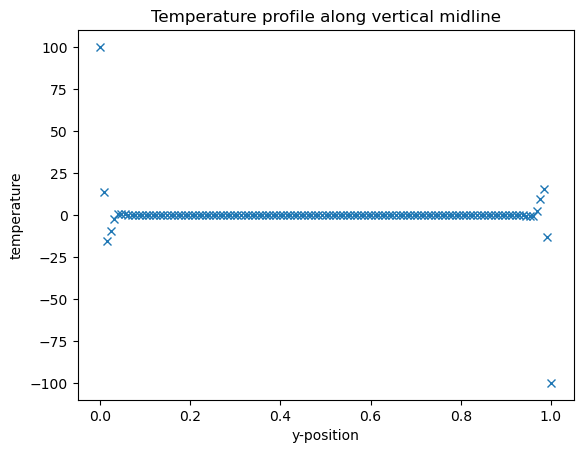

In [7]:
main(params, stability=True)

KSP Object: 1 MPI process
  type: preonly
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
  left preconditioning
  using DEFAULT norm type for convergence test
PC Object: 1 MPI process
  type: lu
  PC has not been set up so information may be incomplete
    out-of-place factorization
    tolerance for zero pivot 2.22045e-14
  linear system matrix = precond matrix:
  Mat Object: 1 MPI process
    type: seqaij
    rows=16641, cols=16641
    total: nonzeros=115457, allocated nonzeros=115457
    total number of mallocs used during MatSetValues calls=0
      not using I-node routines


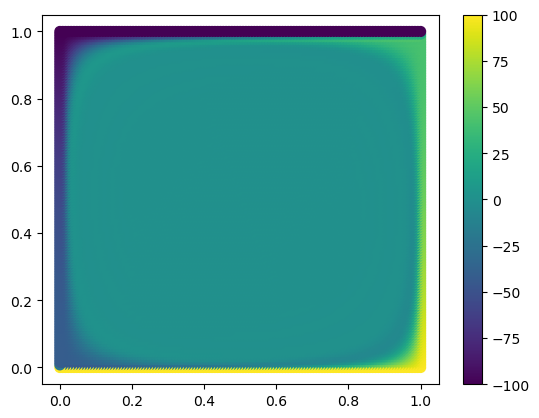

vel-to-alpha scaling: 10000.00


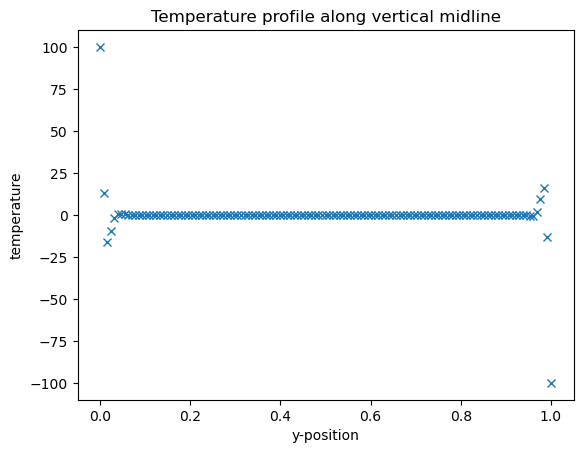

In [8]:
main(params, stability=False)